# 02 Data Cleaning

## Data Quality Assessment and Preprocessing Strategy

### Feature Cardinality Analysis

**Extremely High Cardinality Features (>20k unique values):**
- Key_Skills: 448,048 unique values - requires skill extraction and categorization
- Resume_Title: 426,939 unique values - needs job title classification
- Area_of_Specialization: 29,547 unique values - requires domain grouping
- Preferred_Location: 24,174 unique values - needs geographic consolidation

**Moderate Cardinality Features (100-20k unique values):**
- City: 13,211 unique values - requires focus on major metropolitan areas
- Institute(Highest_Education): 192 unique values - manageable with tiering
- Institute(2nd_Highest_Education): 156 unique values - manageable

**Low Cardinality Features (<100 unique values):**
- Level: 8 unique values - suitable for ordinal encoding
- Course(Highest_Education): 37 unique values - appropriate for categorical analysis
- Course(2nd_Highest_Education): 37 unique values - appropriate for categorical analysis

### Preprocessing Strategy

**High Cardinality Feature Processing:**
- Key_Skills: Implement skill extraction algorithms, create standardized skill categories, consider TF-IDF vectorization
- Resume_Title: Develop job title classification system (technical, management, sales, etc.), evaluate feature importance
- Area_of_Specialization: Create domain-based groupings (IT, Finance, Marketing, Operations)
- Preferred_Location: Implement city tier classification, focus on major metropolitan areas

**Moderate Cardinality Feature Processing:**
- City: Retain top 20-30 cities by frequency, aggregate remaining as "Other Cities"
- Institute names: Create institutional tiers (IITs, NITs, State Universities, Private Institutions)

**Low Cardinality Feature Processing:**
- Level: Implement ordinal encoding based on hierarchical job levels
- Course features: Create education level categories and field classifications

**Special Feature Processing:**
- Salary: Extract numeric values, standardize currency formats, create salary brackets
- Work_Experience: Standardize to years, handle "Fresher" cases, create experience brackets
- DOB: Calculate age, validate date ranges, create age demographic brackets

### Feature Engineering Opportunities

**Interaction Features:**
- Education level × work experience interactions
- Salary per year of experience ratio
- Skills count and diversity metrics
- Geographic region × industry interactions

**Derived Features:**
- Age brackets and career stage classifications
- Education-to-experience ratio
- Skill specialization indices

### Encoding Strategy

**Categorical Encoding:**
- One-hot encoding for Level, Course categories, Institute tiers
- Ordinal encoding for education levels and experience brackets
- Target encoding for high cardinality features
- Text embeddings for skill and title features

This comprehensive preprocessing approach will transform the dataset into a machine learning-ready format while preserving essential information and reducing dimensionality.

In [1]:
import pandas as pd
import numpy as np
import re
from typing import Tuple, List

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel("../Job Seekers.xlsx")

we drop gender, because its empty

In [3]:
df.drop(columns=['Gender'], inplace=True)

In [4]:
# Handle invalid dates by using errors='coerce' to convert problematic dates to NaT
df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce')
df.head()

,City,DOB,Functional_Area,Area_of_Specialization,Industry,Resume_Title,Key_Skills,Salary,Work_Experience,Level,Preferred_Location,Course(Highest_Education),Specialization(Highest_Education),Institute(Highest_Education),Course(2nd_Highest_Education),Specialization(2nd_Highest_Education),Institute(2nd_Highest_Education)
0,HARIDWAR,1986-11-08,Fresh Graduate-No Functional Area exp.,Other Fresh Grad,Retailing,"Pursuing B.Com last year, and with 6 mon diplo...","MS Office,DTP, Internet and smooth operation o...",Rs. 4.88 lacs,6 Year(s) 3 Month(s),Entry Level/Fresher,Delhi,B.Com,Commerce Honors,Jiwaji University,NaN,NaN,NaN
1,AHMEDABAD,1989-05-30,Fresh Graduate-No Functional Area exp.,Other Fresh Grad,Others,Fresh Graduate looking for Job in a co-orporat...,BOARD/UNIVERSITY YEAR OF PASSING B.A Manipur U...,Rs. 12.2 lacs,8 Year(s) 2 Month(s),Entry Level/Fresher,Delhi,B.A.,Pass Course,Others,NaN,NaN,NaN
2,ANAND,1979-12-03,Ticketing/Reservation/Travel Agent/Airlines,Air Hostess,Hotel/Travel/Tourism/Airlines/Hospitality,priti,"diploma in aviation,travel and hospitality fro...",Rs. 7.89 lacs,22 Year(s),Entry Level/Fresher,Delhi,12th,Science,Others,B.A.,Anthropology,Others
3,AZAMGARH,1983-08-02,Finance,Financial Analysis,"Accounting-Tax/Consulting, Banking",ashish mishra,FRESHER,Rs. 7.0 lacs,9 Year(s),Entry Level/Fresher,Anywhere in India,B.Com,Commerce Honors,Others,B.Com,Commerce Honors,Others
4,ANANTNAG,1981-03-23,Marketing/MR/Media Planning,Media Planning,Entertainment/Media,marketing and sales related jobs,institutional sales,Rs. 6.8 lacs,9 Year(s) 5 Month(s),"Junior - Executive, Assistant",Delhi/ NCR,MBA/PGDM,Marketing,Aligarh Muslim University,B.Com,Commerce Pass,Delhi University


Structure of the cleaning process:
- City
- DOB
- Functional_Area
- Area_of_Specialization
- Industry
- Resume_Title
- Key_Skills
- Salay
- Work_Experience
- Level
- Preferred_Location
- Course(Highest_Education)	
- Specialization(Highest_Education)	
- Institute(Highest_Education)
- Course(2nd_Highest_Education)	
- Specialization(2nd_Highest_Education)	
- Institute(2nd_Highest_Education)

---

**Dataframe Overview**

In [5]:
column_names: list[str] = [col for col in df.columns]

missing_values: list[int] = [df[col].isna().sum() for col in column_names]
missing_percentages: list[float] = [df[col].isna().mean() * 100 for col in column_names]
cardinalities: list[int] = [df[col].nunique(dropna=True) for col in column_names]
most_common_10_values: list[list] = [df[col].value_counts(dropna=False).head(10).index.tolist() for col in column_names]

summary_df: pd.DataFrame = pd.DataFrame({
    'column': column_names,
    'missing_values': missing_values,
    'missing_percentage': missing_percentages,
    'cardinality': cardinalities,
    'most_common_10_values': most_common_10_values
})

summary_df

,column,missing_values,missing_percentage,cardinality,most_common_10_values
0,City,676954,74.114940,13211,"[nan, HYDERABAD, BANGALORE, RANGA REDDY, PUNE,..."
1,DOB,8,0.000876,16904,"[1984-05-01 00:00:00, 1960-05-01 00:00:00, 198..."
2,Functional_Area,4564,0.499680,5405,"[IT/Telecom - Software, Fresh Graduate-No Func..."
3,Area_of_Specialization,86465,9.466446,29547,"[nan, Others, Other Fresh Grad, Software Engin..."
4,Industry,36513,3.997552,7020,"[Others, IT-Software, Accounting-Tax/Consultin..."
5,Resume_Title,3130,0.342682,426939,"[Resume, resume, RESUME, CV, CURRICULUM VITAE,..."
6,Key_Skills,86469,9.466884,448048,"[nan, marketing, sales, Marketing, hard workin..."
7,Salary,79998,8.758419,6489,"[nan, 3.0 lacs, INR: 3.00 lacs (PA), 6.0 lacs,..."
8,Work_Experience,9360,1.024761,1101,"[3 Years, 4 Years, 5 Years, 8 Year(s) , nan, 5..."
9,Level,15624,1.710562,8,"[Junior - Executive, Assistant, Entry Level/Fr..."


In [6]:
df.shape

(913384, 17)

---

## 1. City

encode city by taking the most frequent 10 cities and encoding the rest as 'Other'. these will be encoded as dummy variables. this should prevent some dimensionality issues.

In [7]:
def update_city(dataframe: pd.DataFrame) -> pd.DataFrame:
    """Fill missing City values, encode top 10 cities as dummies, rest as 'Other', and drop original City column."""
    dataframe_copy: pd.DataFrame = dataframe.copy()
    dataframe_copy['City'] = dataframe_copy['City'].fillna(dataframe_copy['Preferred_Location'])
    dataframe_copy['City'] = dataframe_copy['City'].fillna("Unknown")
    city_counts: pd.Series = dataframe_copy['City'].value_counts()
    top_10_cities: list[str] = city_counts.head(10).index.tolist()
    city_with_other: pd.Series = dataframe_copy['City'].apply(
        lambda city: city if city in top_10_cities else 'Other'
    )
    city_dummies: pd.DataFrame = pd.get_dummies(city_with_other, prefix='city')
    dataframe_copy = pd.concat([dataframe_copy, city_dummies], axis=1)
    return dataframe_copy

In [8]:
df = update_city(df)

---

## 2. DOB

First i validate the DOB column. and drop anything unrealistically old or young.

In [9]:
number_of_rows_before_drop: int = df.shape[0]
df: pd.DataFrame = df.dropna(subset=['DOB'])
number_of_rows_after_drop: int = df.shape[0]
print(f"Dropped {number_of_rows_before_drop - number_of_rows_after_drop} rows with missing DOB.")

Dropped 8 rows with missing DOB.


In [10]:
def get_dob_validity_bounds() -> Tuple[pd.Timestamp, pd.Timestamp]:
    """Return plausible DOB bounds for job seekers in India (1930-01-01 to 2005-12-31)."""
    minimum_valid_dob: pd.Timestamp = pd.Timestamp('1930-01-01')
    maximum_valid_dob: pd.Timestamp = pd.Timestamp('2005-12-31')
    return minimum_valid_dob, maximum_valid_dob

minimum_valid_dob: pd.Timestamp
maximum_valid_dob: pd.Timestamp
minimum_valid_dob, maximum_valid_dob = get_dob_validity_bounds()

invalid_dob_mask: pd.Series = (df['DOB'] < minimum_valid_dob) | (df['DOB'] > maximum_valid_dob)
valid_dob_mask: pd.Series = ~invalid_dob_mask

print(f"Valid DOB range: {minimum_valid_dob.date()} to {maximum_valid_dob.date()}")
print(f"Records with valid DOB: {valid_dob_mask.sum()}")
print(f"Records with invalid DOB (to drop): {invalid_dob_mask.sum()}")

Valid DOB range: 1930-01-01 to 2005-12-31
Records with valid DOB: 913341
Records with invalid DOB (to drop): 35


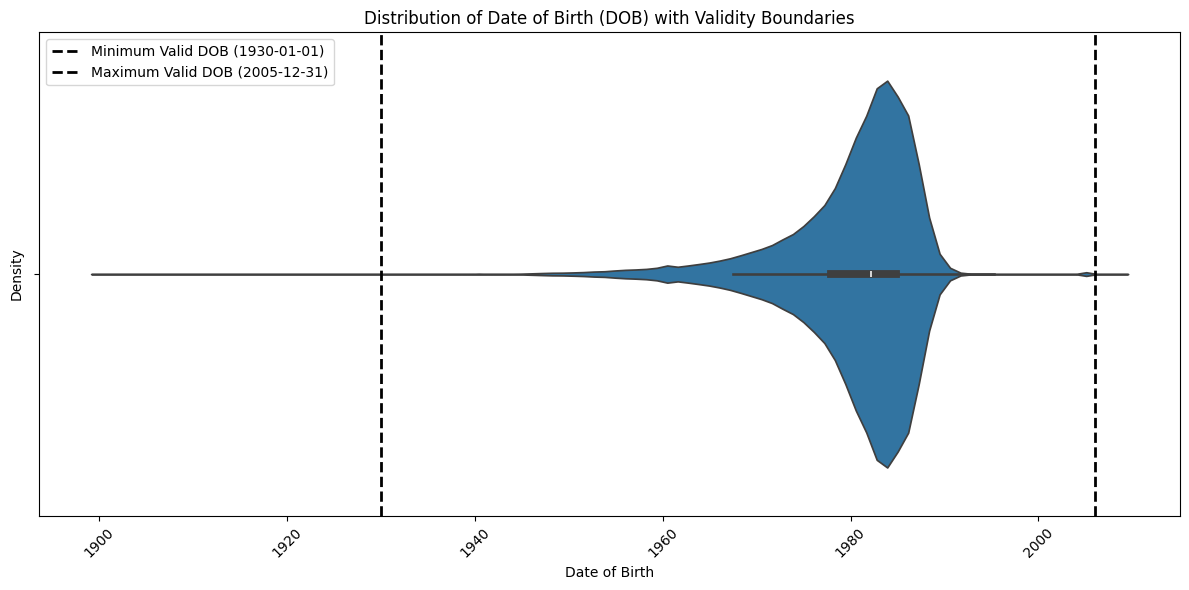

In [11]:
# Create violin plot with DOB boundaries
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='DOB', orient='v')
plt.title('Distribution of Date of Birth (DOB) with Validity Boundaries')
plt.xlabel('Date of Birth')
plt.ylabel('Density')

# Add dashed black lines for minimum and maximum valid DOBs
minimum_valid_dob: pd.Timestamp
maximum_valid_dob: pd.Timestamp
minimum_valid_dob, maximum_valid_dob = get_dob_validity_bounds()

plt.axvline(x=minimum_valid_dob, color='black', linestyle='--', linewidth=2, 
            label=f'Minimum Valid DOB ({minimum_valid_dob.strftime("%Y-%m-%d")})')
plt.axvline(x=maximum_valid_dob, color='black', linestyle='--', linewidth=2, 
            label=f'Maximum Valid DOB ({maximum_valid_dob.strftime("%Y-%m-%d")})')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

DOB values before 1930 may not be plausible and require inspection for data quality issues.

In [12]:
# Filter for DOB values before 1930 and after 2005
dob_outliers_before_1930 = df[df['DOB'] < pd.Timestamp('1930-01-01')]
dob_outliers_after_2005 = df[df['DOB'] > pd.Timestamp('2005-12-31')]

print(f"Records with DOB before 1930: {len(dob_outliers_before_1930)}")
print(f"Records with DOB after 2005: {len(dob_outliers_after_2005)}")

Records with DOB before 1930: 5
Records with DOB after 2005: 30


In [13]:
df = df[df['DOB'] >= pd.Timestamp('1930-01-01')]

Most algorithms such as linear regression, clustering, and logistic regression cannot directly use raw date of birth information, so we calculate age and group it into bins for better modeling.

In [14]:
def calculate_age_from_dob_column(dataframe: pd.DataFrame) -> pd.Series:
    """Calculate age in years from DOB column, assuming DOB is datetime64 or NaT."""
    current_date: pd.Timestamp = pd.Timestamp.today()
    dob_series: pd.Series = dataframe['DOB']
    year_difference: pd.Series = current_date.year - dob_series.dt.year
    has_had_birthday: pd.Series = (
        (dob_series.dt.month < current_date.month) |
        ((dob_series.dt.month == current_date.month) & (dob_series.dt.day <= current_date.day))
    )
    age_series: pd.Series = year_difference - (~has_had_birthday).astype(int)
    return age_series

age_series: pd.Series = calculate_age_from_dob_column(df)
df['age'] = age_series

now we remove DOB

In [15]:
df = df.drop(columns=['DOB'])

---

## 3. Functional Area

In [16]:
df.Functional_Area.nunique()

5405

In [17]:
def clean_text(text: str | float) -> str:
    """Clean text by lowercasing, removing special characters, and normalizing spaces. Return 'Unknown' for missing values."""
    if pd.isna(text):
        return "Unknown"
    cleaned_text: str = re.sub(r'[^a-zA-Z0-9\s,]', '', str(text).lower())
    return ' '.join(cleaned_text.split())

In [18]:
def update_functional_area(dataframe: pd.DataFrame) -> pd.DataFrame:
    """Fill missing Functional_Area values, clean text, then frequency encode Functional_Area."""
    updated_dataframe: pd.DataFrame = dataframe.copy()
    updated_dataframe['Functional_Area'] = updated_dataframe['Functional_Area'].fillna(updated_dataframe['Industry'])
    updated_dataframe['Functional_Area'] = updated_dataframe['Functional_Area'].fillna("Unknown")
    updated_dataframe['Functional_Area'] = updated_dataframe['Functional_Area'].apply(clean_text)
    functional_area_frequency: pd.Series = updated_dataframe['Functional_Area'].value_counts(normalize=True)
    functional_area_frequency_map: dict[str, float] = functional_area_frequency.to_dict()
    updated_dataframe['functional_area_frequency']: pd.Series = updated_dataframe['Functional_Area'].map(functional_area_frequency_map)
    return updated_dataframe

df: pd.DataFrame = update_functional_area(df)

---

## 4. Area of Specialization

The number of unique values is difficult to encode without using an NLP classifier. so i just default to frequency encoding.

In [19]:
df.Area_of_Specialization.nunique()

29547

In [20]:
def update_area_of_specialization(dataframe: pd.DataFrame) -> pd.DataFrame:
    """Fill missing Area_of_Specialization, clean text, then frequency encode Area_of_Specialization."""
    updated_dataframe: pd.DataFrame = dataframe.copy()
    updated_dataframe['Area_of_Specialization'] = updated_dataframe['Area_of_Specialization'].fillna(updated_dataframe['Functional_Area'])
    updated_dataframe['Area_of_Specialization'] = updated_dataframe['Area_of_Specialization'].fillna("Not Specified")
    updated_dataframe['Area_of_Specialization'] = updated_dataframe['Area_of_Specialization'].apply(clean_text)
    area_of_specialization_frequency_map: dict[str, int] = updated_dataframe["Area_of_Specialization"].value_counts().to_dict()
    updated_dataframe["Area_of_Specialization_FE"]: pd.Series = updated_dataframe["Area_of_Specialization"].map(area_of_specialization_frequency_map)
    return updated_dataframe

df: pd.DataFrame = update_area_of_specialization(df)

---

## 5. Industry

In [21]:
df.Industry.nunique()

7020

In [22]:
def update_industry(dataframe: pd.DataFrame) -> pd.DataFrame:
    """Fill missing Industry, clean text, frequency encode, rank, and flag top industries."""
    updated_dataframe: pd.DataFrame = dataframe.copy()
    updated_dataframe['Industry'] = updated_dataframe['Industry'].fillna(updated_dataframe['Functional_Area'])
    updated_dataframe['Industry'] = updated_dataframe['Industry'].fillna("Others")
    updated_dataframe['Industry'] = updated_dataframe['Industry'].apply(clean_text)

    industry_counts: pd.Series = updated_dataframe['Industry'].value_counts()
    updated_dataframe['industry_frequency']: pd.Series = updated_dataframe['Industry'].map(industry_counts)

    industry_rank: pd.Series = industry_counts.rank(method='dense', ascending=False).astype(int)
    industry_rank_dict: dict[str, int] = industry_rank.to_dict()
    updated_dataframe['industry_rank']: pd.Series = updated_dataframe['Industry'].map(industry_rank_dict)

    top_industries: list[str] = industry_counts.head(20).index.tolist()
    updated_dataframe['is_top_industry']: pd.Series = updated_dataframe['Industry'].isin(top_industries).astype(int)

    return updated_dataframe

df: pd.DataFrame = update_industry(df)

---

## 6. Resume Title

In [23]:
df.Resume_Title.nunique()

426937

In [24]:
def update_resume_title(dataframe: pd.DataFrame) -> pd.DataFrame:
    """Fill missing Resume_Title using Functional_Area or a default, remove generic titles, and clean text."""
    dataframe_copy: pd.DataFrame = dataframe.copy()
    missing_resume_title_mask: pd.Series = dataframe_copy['Resume_Title'].isna()
    functional_area_available_mask: pd.Series = dataframe_copy['Functional_Area'].notna()

    fill_with_functional_area_mask: pd.Series = missing_resume_title_mask & functional_area_available_mask
    dataframe_copy.loc[fill_with_functional_area_mask, 'Resume_Title'] = (
        dataframe_copy.loc[fill_with_functional_area_mask, 'Functional_Area'] + " Professional"
    )

    fill_with_default_mask: pd.Series = dataframe_copy['Resume_Title'].isna()
    dataframe_copy.loc[fill_with_default_mask, 'Resume_Title'] = "Unknown Title"

    dataframe_copy['Resume_Title'] = dataframe_copy['Resume_Title'].apply(clean_text)

    generic_titles: set[str] = {"resume", "cv", "curriculum vitae"}
    is_generic_mask: pd.Series = dataframe_copy['Resume_Title'].str.lower().str.strip().isin(generic_titles)
    dataframe_copy = dataframe_copy.loc[~is_generic_mask].reset_index(drop=True)

    return dataframe_copy

df: pd.DataFrame = update_resume_title(df)

---

## 7. Key Skills

In [25]:
df.Key_Skills.nunique()

425998

In [26]:
def update_skills(dataframe: pd.DataFrame) -> pd.DataFrame:
    """Fill missing Key_Skills using Functional_Area and Area_of_Specialization, fallback to 'Unknown'."""
    updated_dataframe: pd.DataFrame = dataframe.copy()
    key_skills_missing_mask: pd.Series = updated_dataframe['Key_Skills'].isna()
    functional_area_str: pd.Series = updated_dataframe['Functional_Area'].astype(str)
    area_of_specialization_str: pd.Series = updated_dataframe['Area_of_Specialization'].astype(str)
    fallback_skills: pd.Series = functional_area_str + ", " + area_of_specialization_str
    fallback_skills = fallback_skills.replace("nan, nan", "Unknown")
    updated_dataframe.loc[key_skills_missing_mask, 'Key_Skills'] = (
        functional_area_str[key_skills_missing_mask] + ", " + area_of_specialization_str[key_skills_missing_mask]
    )
    updated_dataframe['Key_Skills'] = updated_dataframe['Key_Skills'].fillna(fallback_skills)
    updated_dataframe['Key_Skills'] = updated_dataframe['Key_Skills'].replace("nan, nan", "Unknown")
    updated_dataframe['Key_Skills'] = updated_dataframe['Key_Skills'].fillna("Unknown")
    return updated_dataframe

df: pd.DataFrame = update_skills(df)

In [27]:
class ExplainableSkillsProcessor:
    """
    Efficient explainable skills processor using TF-IDF and skill count features.
    Uses vectorized operations and DataFrame assignment for speed.
    """

    def __init__(self, min_frequency: int = 100, max_features: int = 8):
        self.min_frequency: int = min_frequency
        self.max_features: int = max_features
        self.tfidf_vectorizer: TfidfVectorizer | None = None
        self.feature_names: np.ndarray | None = None

    def create_skill_features(self, dataframe: pd.DataFrame, skills_column: str = 'Key_Skills') -> pd.DataFrame:
        """Efficiently creates skill features using TF-IDF and skill count."""
        print("Processing skills...")

        # Clean skills text using the provided clean_text function (vectorized)
        skills_cleaned: pd.Series = dataframe[skills_column].astype(str).map(clean_text)
        dataframe['skills_cleaned'] = skills_cleaned

        # Count number of skills (comma-separated, vectorized)
        skills_count: pd.Series = skills_cleaned.str.split(',').apply(lambda x: sum(bool(s.strip()) for s in x))
        dataframe['skills_count'] = skills_count

        # Create TF-IDF features
        print("Creating TF-IDF features...")
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=self.max_features,
            min_df=self.min_frequency,
            ngram_range=(1, 2),
            stop_words=None
        )
        tfidf_matrix = self.tfidf_vectorizer.fit_transform(skills_cleaned)
        self.feature_names = self.tfidf_vectorizer.get_feature_names_out()

        # Assign all TF-IDF features at once for efficiency
        tfidf_df: pd.DataFrame = pd.DataFrame(
            tfidf_matrix.toarray(),
            columns=[f'skills_tfidf_{i}' for i in range(len(self.feature_names))],
            index=dataframe.index
        )
        dataframe = pd.concat([dataframe, tfidf_df], axis=1)

        print(f"Created {len(self.feature_names)} TF-IDF features")
        print(f"Top features: {self.feature_names}")

        return dataframe

    def explain_skills(self, row_index: int, dataframe: pd.DataFrame) -> dict:
        """Explains skills for a specific row using TF-IDF features and skill count."""
        if row_index not in dataframe.index:
            return {"error": "Row not found"}

        skills_cleaned: str = dataframe.at[row_index, 'skills_cleaned']
        skills_count: int = dataframe.at[row_index, 'skills_count']

        tfidf_features: list[str] = [col for col in dataframe.columns if col.startswith('skills_tfidf_')]
        tfidf_values: np.ndarray = dataframe.loc[row_index, tfidf_features].values

        top_features: list[tuple[str, float]] = list(zip(self.feature_names, tfidf_values))

        return {
            'raw_skills': dataframe.at[row_index, 'Key_Skills'],
            'cleaned_skills': skills_cleaned,
            'total_skills_count': skills_count,
            'tfidf_features': top_features
        }

skills_processor: ExplainableSkillsProcessor = ExplainableSkillsProcessor(
    min_frequency=100,
    max_features=50,
)

df: pd.DataFrame = skills_processor.create_skill_features(df, skills_column='Key_Skills')

explanation: dict = skills_processor.explain_skills(0, df)
print("Skills explanation for row 0:")
for key, value in explanation.items():
    print(f"{key}: {value}")

skill_columns: list[str] = [col for col in df.columns if 'skills' in col.lower()]
print(f"\nNew skill columns created: {skill_columns}")

df.drop(columns=['Key_Skills'], inplace=True)

Processing skills...
Creating TF-IDF features...
Created 50 TF-IDF features
Top features: ['accounting' 'administration' 'and' 'aspnet' 'business' 'civil'
 'commerce' 'communication' 'computer' 'customer' 'data' 'development'
 'engineer' 'excel' 'finance' 'good' 'html' 'in' 'internet' 'java'
 'knowledge' 'management' 'marketing' 'microsoft' 'ms' 'ms office' 'of'
 'office' 'operations' 'oracle' 'other' 'others' 'planning' 'project'
 'sales' 'server' 'service' 'skills' 'software' 'sql' 'sql server'
 'system' 'tax' 'team' 'technologies' 'testing' 'to' 'training' 'windows'
 'with']
Skills explanation for row 0:
raw_skills: MS Office,DTP, Internet and smooth operation of different sorts of tools in computers and also done a diploma course from SSi .
cleaned_skills: ms office,dtp, internet and smooth operation of different sorts of tools in computers and also done a diploma course from ssi
total_skills_count: 3
tfidf_features: [('accounting', np.float64(0.0)), ('administration', np.float64(0

---

Fill all remaining missing values before encoding

In [28]:
df.fillna("Unknown", inplace=True)

---

## 8. Salary

- Salary stored as text with inconsistent formats (e.g., "Rs. X lacs")

In [29]:
def update_salary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and update the 'Salary' column in the DataFrame.
    Extracts numeric salary values in INR (Rs.), handles lacs/lakhs, and fills missing values with the median.
    Also prints the salary bracket distribution.
    """
    import re

    def extract_numeric_salary(salary_text: str) -> float | None:
        """
        Extracts numeric salary value in INR (Rs.) from a salary string.
        Handles formats like 'Rs. X lacs', 'INR: X lacs (PA)', 'X lacs', etc.
        Returns numeric value in Rs. or None if not in Rs.
        """
        if pd.isna(salary_text):
            return None

        salary_text = str(salary_text).strip().upper()

        # Only process if currency is INR
        if not any(currency in salary_text for currency in ['RS', 'INR', '₹']):
            return None

        # Patterns for lacs/lakhs
        patterns: list[str] = [
            r'RS\.?\s*(\d+\.?\d*)\s*LACS?',  # Rs. X lacs
            r'INR:\s*(\d+\.?\d*)\s*LACS?\s*\(PA\)',  # INR: X lacs (PA)
            r'(\d+\.?\d*)\s*LACS?',  # X lacs
            r'RS\.?\s*(\d+\.?\d*)\s*LAC',  # Rs. X lac
            r'INR:\s*(\d+\.?\d*)\s*LAC\s*\(PA\)',  # INR: X lac (PA)
            r'(\d+\.?\d*)\s*LAC',  # X lac
        ]
        for pattern in patterns:
            match = re.search(pattern, salary_text)
            if match:
                numeric_value: float = float(match.group(1))
                return numeric_value * 100000  # 1 lac = 100,000 Rs.

        # Pattern for direct Rs. amount
        rs_pattern: str = r'RS\.?\s*(\d+(?:,\d+)*)'
        match = re.search(rs_pattern, salary_text)
        if match:
            amount_str: str = match.group(1).replace(',', '')
            return float(amount_str)

        return None

    # Apply extraction to Salary column
    df = df.copy()
    df['Salary'] = df['Salary'].apply(extract_numeric_salary)

    # Fill missing with median
    median_salary: float = df['Salary'].median()
    df['Salary'] = df['Salary'].fillna(median_salary)

    # Create salary brackets for analysis
    salary_brackets = pd.cut(
        df['Salary'],
        bins=[0, 300000, 500000, 800000, 1200000, 2000000, float('inf')],
        labels=['0-3L', '3-5L', '5-8L', '8-12L', '12-20L', '20L+']
    )

    print("\nSalary Bracket Distribution:")
    print(salary_brackets.value_counts().sort_index())

    return df

df: pd.DataFrame = update_salary(df)


Salary Bracket Distribution:
Salary
0-3L       11843
3-5L      109006
5-8L      567402
8-12L      69311
12-20L     55210
20L+       34126
Name: count, dtype: int64


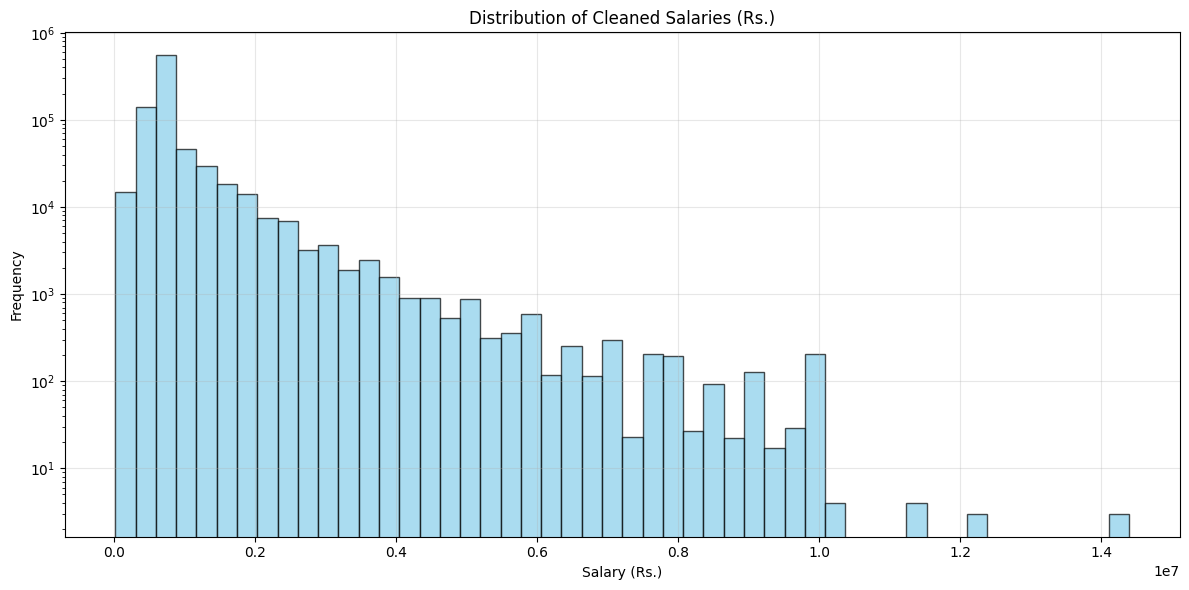

In [30]:
# Create salary distribution plot
plt.figure(figsize=(12, 6))
plt.hist(df['Salary'].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Cleaned Salaries (Rs.)')
plt.xlabel('Salary (Rs.)')
plt.ylabel('Frequency')
plt.yscale('log')  # Log scale due to wide range
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [31]:
rows_with_nan_salary: list[int] = df.index[df['Salary'].isna()].tolist()
df.drop(index=rows_with_nan_salary, inplace=True)

---

## 9. Work Experience

- Work experience formatting inconsistencies (Years vs Year(s))


In [32]:
def update_work_experience(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and standardize the Work_Experience column, add Experience_Years, and infer Level.
    """
    import re
    import pandas as pd

    def parse_experience_text(experience_text: str) -> float | None:
        """Extract total years of experience as float from text, or None if invalid."""
        if pd.isna(experience_text):
            return None

        experience_text = str(experience_text).strip().upper()
        if any(keyword in experience_text for keyword in ['FRESHER', 'NO EXPERIENCE', '0 YEAR', '0 MONTH']):
            return 0.0

        pattern = r'(\d+)\s*YEAR\(?S?\)?\s*(?:(\d+)\s*MONTH\(?S?\)?)?'
        match = re.search(pattern, experience_text)
        if match:
            years: int = int(match.group(1))
            months: int = int(match.group(2)) if match.group(2) else 0
            total_years: float = years + (months / 12)
            return round(total_years, 2)
        return None

    def categorize_experience_level(experience_years: float | None) -> str:
        """Categorize work experience into professional levels."""
        if pd.isna(experience_years):
            return "Unknown"
        if experience_years < 2:
            return "Entry Level"
        elif experience_years < 5:
            return "Junior"
        elif experience_years < 10:
            return "Middle"
        else:
            return "Senior"

    # Clean and standardize Work_Experience to numeric years
    dataframe = dataframe.copy()
    dataframe['Experience_Years']: pd.Series = dataframe['Work_Experience'].apply(parse_experience_text)
    # If Experience_Years is still missing, try to extract from numeric or fallback patterns
    experience_years_filled: pd.Series = dataframe['Experience_Years']

    # If Work_Experience is already numeric, use it where Experience_Years is missing
    numeric_experience: pd.Series = pd.to_numeric(dataframe['Work_Experience'], errors='coerce')
    experience_years_filled = experience_years_filled.fillna(numeric_experience)

    # Fill any remaining missing values with median
    median_experience: float = experience_years_filled.median()
    experience_years_filled = experience_years_filled.fillna(median_experience)
    dataframe['Experience_Years'] = experience_years_filled

    # Overwrite Work_Experience with cleaned numeric years
    dataframe['Work_Experience'] = experience_years_filled

    # Infer Level from Experience_Years
    inferred_levels: pd.Series = dataframe['Experience_Years'].apply(categorize_experience_level)
    if 'Level' not in dataframe.columns:
        dataframe['Level'] = inferred_levels
    else:
        dataframe['Level'] = dataframe['Level'].fillna(inferred_levels)
        dataframe['Level'] = dataframe['Level'].fillna("Unknown")

    return dataframe

df = update_work_experience(df)

---

## 10. Level

In [33]:
df.Level.value_counts()

Level
Junior - Executive, Assistant                    241543
Entry Level/Fresher                              220263
Middle - Manager, Assistant Manager              212615
Others                                            69908
Senior -Sr. Manager, General Manager              55968
Part time                                         18263
Unknown                                           15155
Top - Directors, VP                                8766
Chief Officer - CEO, CMO, COO, CIO, President      4417
Name: count, dtype: int64

In [34]:
def update_level(dataframe: pd.DataFrame, level_column: str = 'Level') -> pd.DataFrame:
    """Add ordinal encoding for job level and drop the original level column."""
    level_mapping: dict[str, int] = {
        'Entry Level/Fresher': 1,
        'Junior - Executive, Assistant': 2,
        'Middle - Manager, Assistant Manager': 3,
        'Senior -Sr. Manager, General Manager': 4,
        'Top - Directors, VP': 5,
        'Chief Officer - CEO, CMO, COO, CIO, President': 6,
        'Part time': 1,
        'Others': 2,
        'Unknown': 2
    }
    dataframe = dataframe.copy()
    dataframe['level_ordinal']: pd.Series = dataframe[level_column].map(level_mapping)
    median_level: float = dataframe['level_ordinal'].median()
    dataframe['level_ordinal'] = dataframe['level_ordinal'].fillna(median_level)
    dataframe = dataframe.drop(columns=[level_column])
    return dataframe

df = update_level(df)

---

## 11. Preferred Location

In [35]:
def update_location(dataframe: pd.DataFrame, preferred_location_column: str = 'Preferred_Location', city_column: str = 'City') -> pd.DataFrame:
    """Fill missing preferred location, encode count and flexibility of preferred locations."""
    dataframe_copy: pd.DataFrame = dataframe.copy()
    dataframe_copy[preferred_location_column] = dataframe_copy[preferred_location_column].fillna(dataframe_copy[city_column])
    dataframe_copy[preferred_location_column] = dataframe_copy[preferred_location_column].fillna("No Preference")
    preferred_location_counts: pd.Series = dataframe_copy[preferred_location_column].fillna('').apply(
        lambda locations: len([loc.strip() for loc in str(locations).split(',') if loc.strip()])
    )
    dataframe_copy['preferred_location_count']: pd.Series = preferred_location_counts
    dataframe_copy['preferred_location_flexible']: pd.Series = preferred_location_counts > 1
    return dataframe_copy

df: pd.DataFrame = update_location(df, preferred_location_column='Preferred_Location', city_column='City')

---

## 12. Education

- Course(Highest_Education)	
- Specialization(Highest_Education)	
- Institute(Highest_Education)
- Course(2nd_Highest_Education)	
- Specialization(2nd_Highest_Education)	
- Institute(2nd_Highest_Education)

In [36]:
def fill_education_missing_values(dataframe: pd.DataFrame) -> pd.DataFrame:
    """Efficiently fill missing values in education-related columns using logical fallbacks."""
    dataframe_copy: pd.DataFrame = dataframe.copy()

    # Fill Institute(Highest_Education) with 'Unknown Institute'
    dataframe_copy['Institute(Highest_Education)'] = dataframe_copy['Institute(Highest_Education)'].fillna('Unknown Institute')

    # Fill Course(Highest_Education) with Course(2nd_Highest_Education) if available, else 'Unknown Course'
    dataframe_copy['Course(Highest_Education)'] = dataframe_copy['Course(Highest_Education)'].fillna(
        dataframe_copy['Course(2nd_Highest_Education)']
    ).fillna('Unknown Course')

    # Fill Specialization(Highest_Education) with Course(Highest_Education) if available, else 'General'
    dataframe_copy['Specialization(Highest_Education)'] = dataframe_copy['Specialization(Highest_Education)'].fillna(
        dataframe_copy['Course(Highest_Education)']
    ).fillna('General')

    # Fill 2nd highest education columns with 'None'
    dataframe_copy[['Course(2nd_Highest_Education)', 'Specialization(2nd_Highest_Education)', 'Institute(2nd_Highest_Education)']] = \
        dataframe_copy[['Course(2nd_Highest_Education)', 'Specialization(2nd_Highest_Education)', 'Institute(2nd_Highest_Education)']].fillna('None')

    return dataframe_copy

df: pd.DataFrame = fill_education_missing_values(df)

def encode_institute_tiers(dataframe: pd.DataFrame, institute_columns: list[str]) -> pd.DataFrame:
    """Efficiently encode institute columns using simple tier classification."""
    dataframe_copy: pd.DataFrame = dataframe.copy()
    tier_1_institutes: set[str] = {
        'IIT', 'IIM', 'AIIMS', 'NIT', 'BITS PILANI', 'IISC', 'ISB', 'XLRI', 'SPJIMR'
    }
    tier_2_institutes: set[str] = {
        'DELHI UNIVERSITY', 'JNU', 'JADAVPUR UNIVERSITY', 'ANNA UNIVERSITY', 'UNIVERSITY OF MUMBAI',
        'UNIVERSITY OF CALCUTTA', 'ALIGARH MUSLIM UNIVERSITY', 'BANARAS HINDU UNIVERSITY'
    }

    def classify_institute(institute_name: str) -> str:
        """Classify institute into Tier 1, Tier 2, or Other."""
        if not isinstance(institute_name, str) or not institute_name.strip():
            return 'Other'
        normalized_name: str = institute_name.strip().upper()
        if any(tier_1 in normalized_name for tier_1 in tier_1_institutes):
            return 'Tier 1'
        if any(tier_2 in normalized_name for tier_2 in tier_2_institutes):
            return 'Tier 2'
        return 'Other'

    for institute_column in institute_columns:
        tier_column_name: str = f"{institute_column}_tier"
        dataframe_copy[tier_column_name] = dataframe_copy[institute_column].apply(classify_institute)
    return dataframe_copy

institute_columns: list[str] = [
    'Institute(Highest_Education)',
    'Institute(2nd_Highest_Education)'
]
df: pd.DataFrame = encode_institute_tiers(df, institute_columns)

def encode_education_features(df: pd.DataFrame) -> pd.DataFrame:
    """Efficiently encode education course and specialization columns with one-hot encoding."""
    # Course(Highest_Education)
    course_highest_mapping: dict[str, str] = {
        'MBA/PGDM': 'management', 'BBA': 'management', 'M.Com': 'management',
        'BE/B.Tech': 'engineering', 'ME/M.Tech': 'engineering', 'B.Arch': 'engineering',
        'B.Com': 'commerce', 'CA': 'commerce', 'ICWA': 'commerce',
        'B.A.': 'arts', 'MA': 'arts',
        'B.Sc': 'science', 'M.Sc': 'science',
        'BCA': 'computer', 'MCA/PGDCA': 'computer',
        'Diploma': 'diploma', '12th': 'school'
    }
    df['course_highest_simple']: pd.Series = df['Course(Highest_Education)'].map(course_highest_mapping).fillna('other')
    df = pd.concat([df, pd.get_dummies(df['course_highest_simple'], prefix='course_highest')], axis=1)

    # Course(2nd_Highest_Education)
    course_second_mapping: dict[str, str] = {
        'None': 'none', 'MBA/PGDM': 'management', 'BBA': 'management',
        'B.Com': 'commerce', 'BE/B.Tech': 'engineering', 'B.A.': 'arts',
        'B.Sc': 'science', 'BCA': 'computer', 'Diploma': 'diploma', '12th': 'school'
    }
    df['course_second_simple']: pd.Series = df['Course(2nd_Highest_Education)'].map(course_second_mapping).fillna('other')
    df = pd.concat([df, pd.get_dummies(df['course_second_simple'], prefix='course_second')], axis=1)

    # Specialization(Highest_Education)
    top_specs_highest: list[str] = df['Specialization(Highest_Education)'].value_counts().nlargest(10).index.tolist()
    df['specialization_highest_top10']: pd.Series = df['Specialization(Highest_Education)'].where(
        df['Specialization(Highest_Education)'].isin(top_specs_highest), 'other'
    )
    df = pd.concat([df, pd.get_dummies(df['specialization_highest_top10'], prefix='spec_highest')], axis=1)

    # Specialization(2nd_Highest_Education)
    top_specs_second: list[str] = df['Specialization(2nd_Highest_Education)'].value_counts().nlargest(10).index.tolist()
    df['specialization_second_top10']: pd.Series = df['Specialization(2nd_Highest_Education)'].where(
        df['Specialization(2nd_Highest_Education)'].isin(top_specs_second), 'other'
    )
    df = pd.concat([df, pd.get_dummies(df['specialization_second_top10'], prefix='spec_second')], axis=1)

    return df

df: pd.DataFrame = encode_education_features(df)

columns_to_drop: list[str] = [
    'Course(Highest_Education)',
    'Course(2nd_Highest_Education)', 
    'Specialization(Highest_Education)',
    'Specialization(2nd_Highest_Education)'
]
df.drop(columns=columns_to_drop, inplace=True)


---

drop columns that are encoded

In [37]:
df.drop(columns=['Work_Experience', 'Resume_Title', 'Area_of_Specialization', 'skills_cleaned', 'skills_count'], inplace=True)

---

In [38]:
def show_categorical_columns(dataframe: pd.DataFrame) -> List[str]:
    """Return a list of categorical columns in the dataframe"""
    categorical_column_names: List[str] = dataframe.select_dtypes(include=['object', 'category']).columns.tolist()
    return df[categorical_column_names]

show_categorical_columns(df)

,City,Functional_Area,Industry,Preferred_Location,Institute(Highest_Education),Institute(2nd_Highest_Education),Institute(Highest_Education)_tier,Institute(2nd_Highest_Education)_tier,course_highest_simple,course_second_simple,specialization_highest_top10,specialization_second_top10
0,HARIDWAR,fresh graduateno functional area exp,retailing,Delhi,Jiwaji University,Unknown,Other,Other,commerce,other,Commerce Honors,Unknown
1,AHMEDABAD,fresh graduateno functional area exp,others,Delhi,Others,Unknown,Other,Other,arts,other,other,Unknown
2,ANAND,ticketingreservationtravel agentairlines,hoteltraveltourismairlineshospitality,Delhi,Others,Others,Other,Other,school,arts,other,other
3,AZAMGARH,finance,"accountingtaxconsulting, banking",Anywhere in India,Others,Others,Other,Other,commerce,commerce,Commerce Honors,Commerce Honors
4,ANANTNAG,marketingmrmedia planning,entertainmentmedia,Delhi/ NCR,Aligarh Muslim University,Delhi University,Tier 2,Tier 2,management,commerce,Marketing,Commerce Pass
...,...,...,...,...,...,...,...,...,...,...,...,...
846893,RANGAREDDY,service engineers,consumer durablesfmcg,Delhi,Delhi College of Engineering,Delhi University,Other,Tier 2,diploma,commerce,other,other
846894,DEVBHUMI DWARKA,engg project mgmtsite enggcivil engg,engineeringprojects,Delhi,Unknown,Ranchi University,Other,Other,engineering,commerce,Mechanical,Others
846895,RANGA REDDY HYDERABAD,fresh graduateno functional area exp,itsoftware,Delhi,Unknown,Others,Other,Other,computer,school,other,Others
846896,PUNE,"ittelecom hardware, ittelecom software",telecom,"Delhi,Faridabad,Ghaziabad,Gurgaon,Noida/ Great...",Others,Unknown,Other,Other,engineering,other,Electronics/Telecommunication,Unknown


In [39]:
# Final encoding for ML-ready dataset
def final_encoding_for_ml(df):
    """Apply final encoding to make data ML-ready"""
    
    # List of categorical columns to encode
    categorical_columns = [
        'course_highest_simple',
        'course_second_simple',
        'specialization_highest_top10',
        'specialization_second_top10'
    ]
    
    # One-hot encode all categorical columns
    df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
    
    return df_encoded

In [40]:
df = final_encoding_for_ml(df)

In [41]:
categorical_column_names: List[str] = df.select_dtypes(include=['object', 'category']).columns.tolist()
df.drop(columns=categorical_column_names, inplace=True)

In [42]:
# Check final shape
print(f"Final dataset shape: {df.shape}")
print(f"Number of features: {df.shape[1]}")

Final dataset shape: (846898, 148)
Number of features: 148


---

## THREE BUSINESS-CRITICAL QUESTIONS:


### Q1 - Clustering (10 marks):
"What are the distinct job seeker segments in the Indian market, and how can recruiters target them effectively?"

- Clustering → Talent Segmentation → Better recruitment strategies

**Business Impact:**
- Helps recruiters understand different talent pools
- Enables targeted recruitment strategies
- Optimizes job posting placement
- Reduces hiring costs and time

**Clustering Approach:**
- Segment by skills, experience, education, location, salary expectations
- Identify natural groupings (e.g., "Senior Tech Professionals", "Fresh Graduates", "Mid-career Switchers")
- Create recruitment personas for each segment

In [43]:
from sklearn.cluster import KMeans

Sanity check: feature distributions before clustering


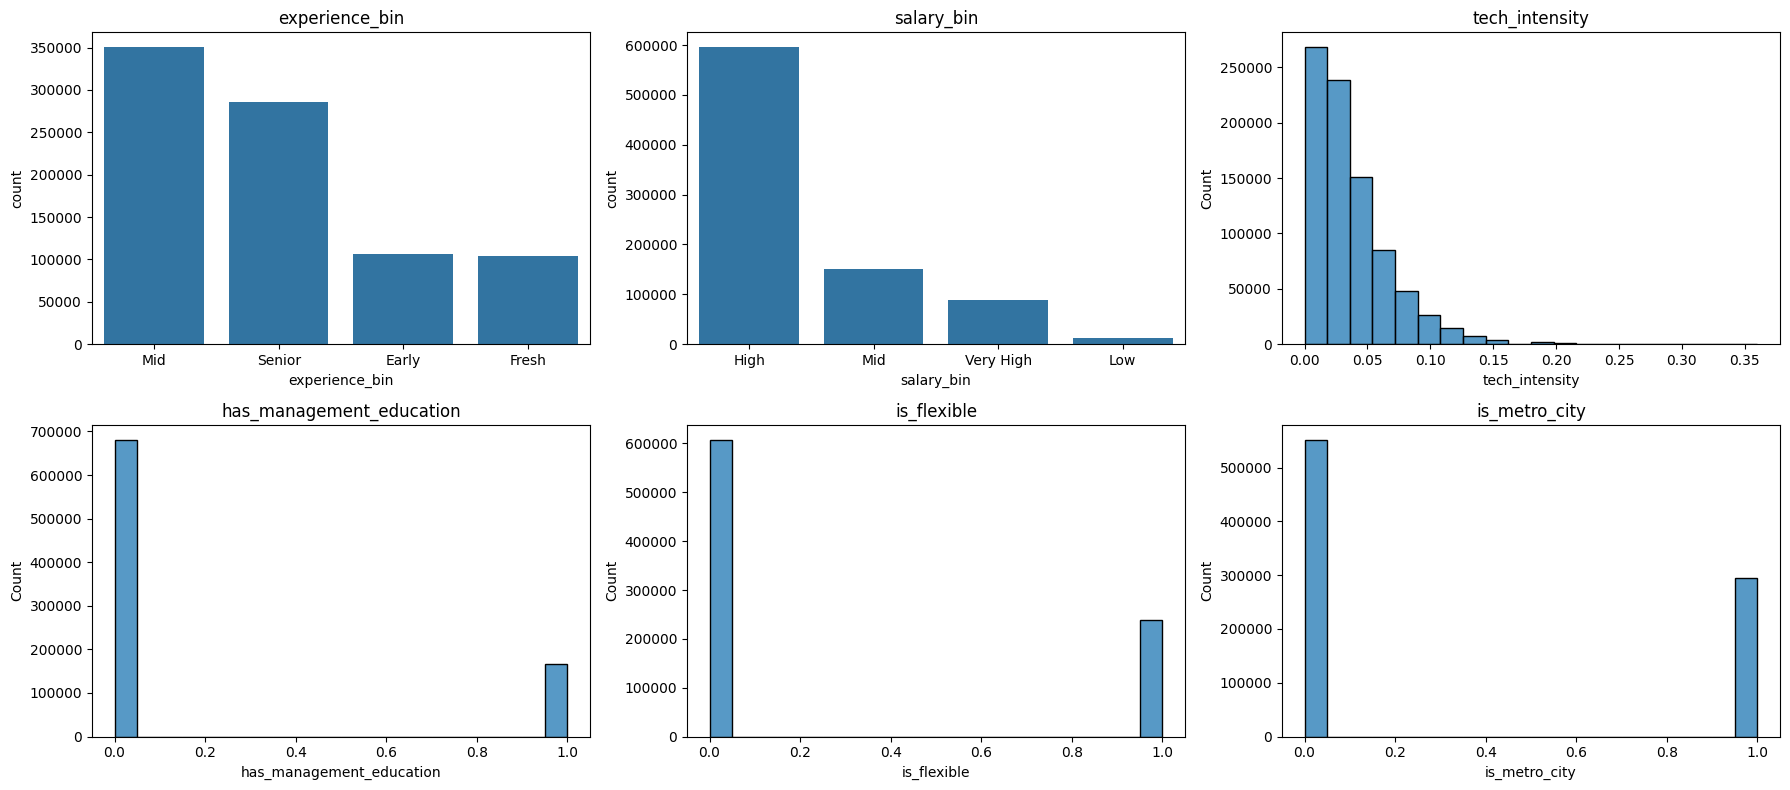

Using 12 interpretable features for clustering: ['tech_intensity', 'has_management_education', 'is_flexible', 'is_metro_city', 'experience_bin_Fresh', 'experience_bin_Early', 'experience_bin_Mid', 'experience_bin_Senior', 'salary_bin_Low', 'salary_bin_Mid', 'salary_bin_High', 'salary_bin_Very High']
KMeans elbow plot for cluster count selection:


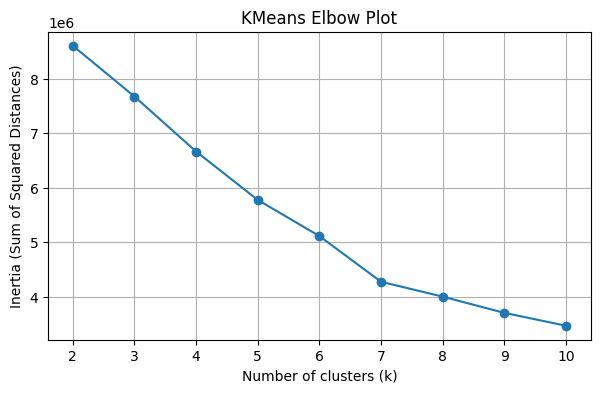

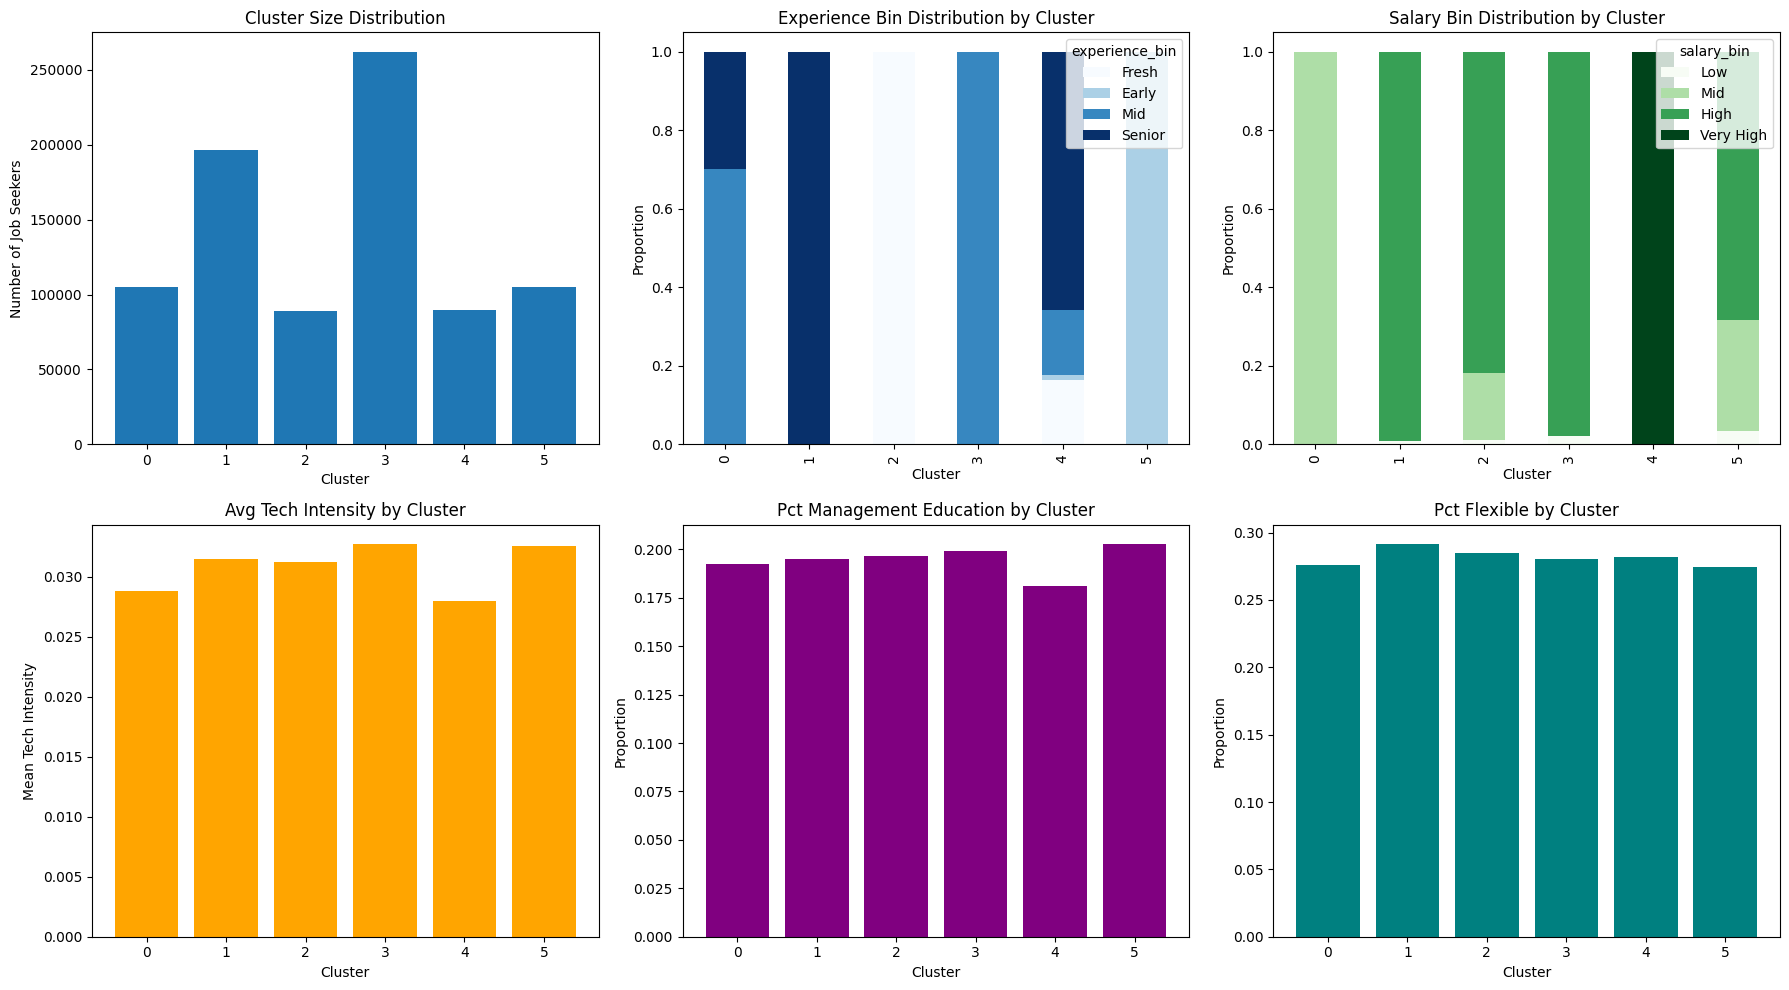

=== JOB SEEKER SEGMENTATION RESULTS (KMEANS, BUSINESS-INTERPRETABLE) ===
Total job seekers analyzed: 846,898
Number of segments identified: 6
Features used: 12

=== CLUSTER PROFILES (Business Table) ===
 Cluster   Size  Percentage Experience    Salary  Tech  Mgmt  Flex  Metro
       0 104964       12.39        Mid       Mid  0.03  0.19  0.28   0.30
       1 196321       23.18     Senior      High  0.03  0.20  0.29   0.35
       2  89033       10.51      Fresh      High  0.03  0.20  0.28   0.35
       3 262035       30.94        Mid      High  0.03  0.20  0.28   0.38
       4  89336       10.55     Senior Very High  0.03  0.18  0.28   0.26
       5 105209       12.42      Early      High  0.03  0.20  0.27   0.39

=== Cluster Results ===

Cluster 0 (104,964 job seekers, 12.4%):
Segment profile: Experience: Mid, Salary: Mid
Recruiter action: Generalist or mixed targeting.

Cluster 1 (196,321 job seekers, 23.2%):
Segment profile: Experience: Senior, Salary: High
Recruiter action: Executive

In [44]:
def create_composite_features(df: pd.DataFrame) -> pd.DataFrame:
    """Creates interpretable composite features for clustering tied to business levers, with robust metro and tech features."""
    df = df.copy()
    # Experience bins: 0-1, 2-4, 5-9, 10+
    df['experience_bin'] = pd.cut(
        df['Experience_Years'],
        bins=[-1, 1, 4, 9, 100],
        labels=['Fresh', 'Early', 'Mid', 'Senior']
    )
    # Salary bins (hand-crafted, adjust as needed)
    df['salary_bin'] = pd.cut(
        df['Salary'],
        bins=[-1, 300000, 600000, 1200000, 99999999],
        labels=['Low', 'Mid', 'High', 'Very High']
    )
    # Tech intensity: binary, at least one nonzero skill tfidf
    skills_cols: list[str] = [col for col in df.columns if col.startswith('skills_tfidf_')]
    if skills_cols:
        # Count of nonzero skills, normalized by number of skills columns
        df['tech_intensity'] = (df[skills_cols] > 0).sum(axis=1) / len(skills_cols)
    else:
        df['tech_intensity'] = 0.0
    # Management education: binary
    df['has_management_education'] = df['course_highest_simple_management'] if 'course_highest_simple_management' in df.columns else 0
    # Flexibility: already binary
    df['is_flexible'] = df['preferred_location_flexible'] if 'preferred_location_flexible' in df.columns else 0
    # City tier: Metro vs Other (robust, works if any metro dummy is present)
    metro_city_prefixes: list[str] = ['city_Delhi', 'city_Delhi/ NCR', 'city_Mumbai', 'city_Bangalore', 'city_Chennai', 'city_Kolkata']
    metro_city_cols: list[str] = [col for col in df.columns if col in metro_city_prefixes]
    if metro_city_cols:
        df['is_metro_city'] = df[metro_city_cols].sum(axis=1).astype(int)
        df['is_metro_city'] = (df['is_metro_city'] > 0).astype(int)
    else:
        df['is_metro_city'] = 0
    return df

def encode_composite_features(df: pd.DataFrame) -> pd.DataFrame:
    """Encodes composite features for clustering."""
    df = df.copy()
    # One-hot encode experience_bin and salary_bin
    for col in ['experience_bin', 'salary_bin']:
        if col in df.columns:
            dummies = pd.get_dummies(df[col], prefix=col)
            df = pd.concat([df, dummies], axis=1)
    # No need to encode tech_intensity, has_management_education, is_flexible, is_metro_city (already numeric)
    return df

def select_final_clustering_features(df: pd.DataFrame) -> list[str]:
    """Selects the final interpretable features for clustering."""
    features: list[str] = [
        'tech_intensity',
        'has_management_education',
        'is_flexible',
        'is_metro_city'
    ]
    # Add one-hot columns for experience and salary bins
    features += [col for col in df.columns if col.startswith('experience_bin_')]
    features += [col for col in df.columns if col.startswith('salary_bin_')]
    available_features: list[str] = [col for col in features if col in df.columns]
    print(f"Using {len(available_features)} interpretable features for clustering: {available_features}")
    return available_features

def create_kmeans_cluster_profiles(df: pd.DataFrame, feature_columns: list[str]) -> pd.DataFrame:
    """Creates summary profiles for each KMeans cluster."""
    cluster_labels: np.ndarray = df['cluster'].unique()
    cluster_profiles: list[dict] = []
    for cluster_id in sorted(cluster_labels):
        cluster_data: pd.DataFrame = df[df['cluster'] == cluster_id]
        profile: dict = {
            'Cluster': cluster_id,
            'Size': len(cluster_data),
            'Percentage': len(cluster_data) / len(df) * 100,
            'Experience': cluster_data['experience_bin'].mode()[0] if 'experience_bin' in cluster_data.columns and not cluster_data['experience_bin'].isna().all() else None,
            'Salary': cluster_data['salary_bin'].mode()[0] if 'salary_bin' in cluster_data.columns and not cluster_data['salary_bin'].isna().all() else None,
            'Tech': cluster_data['tech_intensity'].mean() if 'tech_intensity' in cluster_data.columns else np.nan,
            'Mgmt': cluster_data['has_management_education'].mean() if 'has_management_education' in cluster_data.columns else np.nan,
            'Flex': cluster_data['is_flexible'].mean() if 'is_flexible' in cluster_data.columns else np.nan,
            'Metro': cluster_data['is_metro_city'].mean() if 'is_metro_city' in cluster_data.columns else np.nan,
        }
        cluster_profiles.append(profile)
    cluster_profiles_df: pd.DataFrame = pd.DataFrame(cluster_profiles)
    return cluster_profiles_df

def visualize_feature_distributions(df: pd.DataFrame) -> None:
    """Visual sanity checks: histograms for key features before clustering."""
    features_to_plot: list[str] = [
        'experience_bin', 'salary_bin', 'tech_intensity',
        'has_management_education', 'is_flexible', 'is_metro_city'
    ]
    n_features: int = len(features_to_plot)
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    axes = axes.flatten()
    for idx, feature in enumerate(features_to_plot):
        ax = axes[idx]
        if feature in df.columns:
            if df[feature].dtype.name == 'category' or df[feature].dtype == object:
                sns.countplot(x=df[feature], ax=ax, order=df[feature].value_counts().index)
            else:
                sns.histplot(df[feature], ax=ax, bins=20, kde=False)
            ax.set_title(feature)
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()

def plot_kmeans_elbow(X: np.ndarray, max_k: int = 10, random_state: int = 42) -> None:
    """Plots KMeans inertia (elbow) to justify cluster count."""
    inertias: list[float] = []
    k_range: range = range(2, max_k + 1)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    plt.figure(figsize=(7, 4))
    plt.plot(list(k_range), inertias, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia (Sum of Squared Distances)')
    plt.title('KMeans Elbow Plot')
    plt.xticks(list(k_range))
    plt.grid(True)
    plt.show()

def visualize_kmeans_clusters(df: pd.DataFrame) -> None:
    """Visualizes KMeans cluster characteristics in a 2x3 grid."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    # 1. Cluster size distribution
    cluster_sizes = df['cluster'].value_counts().sort_index()
    axes[0].bar(cluster_sizes.index, cluster_sizes.values)
    axes[0].set_title('Cluster Size Distribution')
    axes[0].set_xlabel('Cluster')
    axes[0].set_ylabel('Number of Job Seekers')

    # 2. Experience bin by cluster
    if 'experience_bin' in df.columns:
        exp_bin_dist = pd.crosstab(df['cluster'], df['experience_bin'], normalize='index')
        exp_bin_dist.plot(kind='bar', stacked=True, ax=axes[1], colormap='Blues')
        axes[1].set_title('Experience Bin Distribution by Cluster')
        axes[1].set_xlabel('Cluster')
        axes[1].set_ylabel('Proportion')
    else:
        axes[1].set_visible(False)

    # 3. Salary bin by cluster
    if 'salary_bin' in df.columns:
        salary_bin_dist = pd.crosstab(df['cluster'], df['salary_bin'], normalize='index')
        salary_bin_dist.plot(kind='bar', stacked=True, ax=axes[2], colormap='Greens')
        axes[2].set_title('Salary Bin Distribution by Cluster')
        axes[2].set_xlabel('Cluster')
        axes[2].set_ylabel('Proportion')
    else:
        axes[2].set_visible(False)

    # 4. Tech intensity by cluster
    if 'tech_intensity' in df.columns:
        tech_intensity = df.groupby('cluster')['tech_intensity'].mean()
        axes[3].bar(tech_intensity.index, tech_intensity.values, color='orange')
        axes[3].set_title('Avg Tech Intensity by Cluster')
        axes[3].set_xlabel('Cluster')
        axes[3].set_ylabel('Mean Tech Intensity')
    else:
        axes[3].set_visible(False)

    # 5. Management education by cluster
    if 'has_management_education' in df.columns:
        mgmt_ed = df.groupby('cluster')['has_management_education'].mean()
        axes[4].bar(mgmt_ed.index, mgmt_ed.values, color='purple')
        axes[4].set_title('Pct Management Education by Cluster')
        axes[4].set_xlabel('Cluster')
        axes[4].set_ylabel('Proportion')
    else:
        axes[4].set_visible(False)

    # 6. Flexibility by cluster
    if 'is_flexible' in df.columns:
        flex = df.groupby('cluster')['is_flexible'].mean()
        axes[5].bar(flex.index, flex.values, color='teal')
        axes[5].set_title('Pct Flexible by Cluster')
        axes[5].set_xlabel('Cluster')
        axes[5].set_ylabel('Proportion')
    else:
        axes[5].set_visible(False)

    plt.tight_layout()
    plt.show()

# === MAIN CLUSTERING WORKFLOW (BUSINESS-INTERPRETABLE) ===

# Step 1: Create composite features
df_composite: pd.DataFrame = create_composite_features(df)
df_composite = encode_composite_features(df_composite)

# Step 2: Visual sanity checks on input distributions
print("Sanity check: feature distributions before clustering")
visualize_feature_distributions(df_composite)

# Step 3: Select interpretable features
final_features: list[str] = select_final_clustering_features(df_composite)
X_final: pd.DataFrame = df_composite[final_features].fillna(0)

# Step 4: Elbow plot for K selection
scaler: StandardScaler = StandardScaler()
X_final_scaled: np.ndarray = scaler.fit_transform(X_final)
print("KMeans elbow plot for cluster count selection:")
plot_kmeans_elbow(X_final_scaled, max_k=10, random_state=42)

# Step 5: Lightweight clustering (KMeans)
kmeans_n_clusters: int = 6  # Chosen based on elbow plot
kmeans_random_state: int = 42

kmeans: KMeans = KMeans(n_clusters=kmeans_n_clusters, random_state=kmeans_random_state, n_init=10)
kmeans_labels: np.ndarray = kmeans.fit_predict(X_final_scaled)
df_composite['cluster'] = kmeans_labels

cluster_labels: list[int] = sorted(df_composite['cluster'].unique())
n_clusters: int = len(cluster_labels)

# Step 6: Create summary profiles
cluster_profiles_df: pd.DataFrame = create_kmeans_cluster_profiles(df_composite, final_features)

# Step 7: Visualize clusters
visualize_kmeans_clusters(df_composite)

# Step 8: Print summary
print("=== JOB SEEKER SEGMENTATION RESULTS (KMEANS, BUSINESS-INTERPRETABLE) ===")
print(f"Total job seekers analyzed: {len(df_composite):,}")
print(f"Number of segments identified: {n_clusters}")
print(f"Features used: {len(final_features)}")
print("\n=== CLUSTER PROFILES (Business Table) ===")
display_cols: list[str] = ['Cluster', 'Size', 'Percentage', 'Experience', 'Salary', 'Tech', 'Mgmt', 'Flex', 'Metro']
print(cluster_profiles_df[display_cols].round(2).to_string(index=False))

print("\n=== Cluster Results ===")
for _, profile in cluster_profiles_df.iterrows():
    cluster_id: int = int(profile['Cluster'])
    size: int = int(profile['Size'])
    exp_bin = profile['Experience']
    salary_bin = profile['Salary']
    tech: float = profile['Tech']
    mgmt: float = profile['Mgmt']
    flex: float = profile['Flex']
    metro: float = profile['Metro']

    print(f"\nCluster {cluster_id} ({size:,} job seekers, {profile['Percentage']:.1f}%):")
    summary = []
    if exp_bin is not None:
        summary.append(f"Experience: {exp_bin}")
    if salary_bin is not None:
        summary.append(f"Salary: {salary_bin}")
    if tech > 0.5:
        summary.append("Tech-heavy")
    if mgmt > 0.5:
        summary.append("MBA/Management education")
    if flex > 0.5:
        summary.append("High flexibility")
    if metro > 0.5:
        summary.append("Metro city")
    if not summary:
        summary.append("Generalist segment")
    print("Segment profile: " + ", ".join(summary))

    # Example recruiter targeting
    if tech > 0.5 and exp_bin in ['Mid', 'Early'] and flex > 0.5:
        print("Recruiter action: Pitch remote-first engineering roles at appropriate salary band.")
    elif mgmt > 0.5 and flex < 0.5 and metro > 0.5:
        print("Recruiter action: Target leadership/management tracks in metro offices.")
    elif exp_bin == 'Fresh':
        print("Recruiter action: Entry-level programs, internships, training.")
    elif exp_bin == 'Senior':
        print("Recruiter action: Executive/strategic positions, high CTC.")
    else:
        print("Recruiter action: Generalist or mixed targeting.")

- TODO: ensure full data availability before next step

---

### Q2 - Linear Regression (10 marks):


In [82]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Compute mean absolute percentage error (MAPE)."""
    y_true_safe: np.ndarray = np.where(y_true == 0, np.finfo(float).eps, y_true)
    mape: float = np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100
    return mape

def root_mean_squared_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Compute root mean squared error (RMSE)."""
    mse: float = mean_squared_error(y_true, y_pred)
    rmse: float = np.sqrt(mse)
    return rmse

def engineer_simple_features(dataframe: pd.DataFrame) -> pd.DataFrame:
    """Engineer simple, interpretable features for job level prediction."""
    df_engineered: pd.DataFrame = dataframe.copy()
    if "age" in df_engineered.columns and "Experience_Years" in df_engineered.columns:
        age_experience_interaction: pd.Series = df_engineered["age"] * df_engineered["Experience_Years"]
        age_minus_experience: pd.Series = df_engineered["age"] - df_engineered["Experience_Years"]
        df_engineered["age_experience_interaction"] = age_experience_interaction
        df_engineered["age_minus_experience"] = age_minus_experience
    # Only add education_level_ordinal_used if it is not entirely missing
    if "education_level_ordinal" in df_engineered.columns and not df_engineered["education_level_ordinal"].isna().all():
        education_level_ordinal_used: pd.Series = df_engineered["education_level_ordinal"]
        df_engineered["education_level_ordinal_used"] = education_level_ordinal_used
    elif "num_highest_courses" in df_engineered.columns and not df_engineered["num_highest_courses"].isna().all():
        education_level_ordinal_used: pd.Series = df_engineered["num_highest_courses"]
        df_engineered["education_level_ordinal_used"] = education_level_ordinal_used
    # If both are missing or all missing, do not add the column at all
    return df_engineered

def select_simple_features(dataframe: pd.DataFrame) -> list[str]:
    """Select a simple, robust set of features for job level prediction."""
    candidate_features: list[str] = [
        "age",
        "Experience_Years",
        "education_level_ordinal_used",
        "age_experience_interaction",
        "age_minus_experience",
    ]
    available_features: list[str] = [feature for feature in candidate_features if feature in dataframe.columns]
    return available_features

def print_missing_data_report(dataframe: pd.DataFrame, features: list[str], target: str) -> None:
    """Print a report of missing data for selected features and target."""
    missing_report: dict[str, int] = {}
    for column in features + [target]:
        if column in dataframe.columns:
            missing_count: int = dataframe[column].isna().sum()
        else:
            missing_count: int = -1
        missing_report[column] = missing_count
    print("Missing data report for selected features and target:")
    for column, missing_count in missing_report.items():
        if missing_count == -1:
            print(f"  {column}: column not found in DataFrame")
        else:
            print(f"  {column}: {missing_count} missing")

def predict_job_level_with_ridge(dataframe: pd.DataFrame) -> None:
    """
    Fit a Ridge regression model to predict job level (level_ordinal) from simple engineered features.
    Prints R², MAE, RMSE, MAPE, and feature importances.
    If no data is available after dropping missing values, prints a detailed missing data report.
    """
    df_engineered: pd.DataFrame = engineer_simple_features(dataframe)
    selected_features: list[str] = select_simple_features(df_engineered)
    if "level_ordinal" not in df_engineered.columns:
        raise ValueError("level_ordinal column not found in the DataFrame.")

    model_dataframe: pd.DataFrame = df_engineered[selected_features + ["level_ordinal"]].dropna()
    if model_dataframe.empty:
        print("No data available after dropping missing values for selected features and target.")
        print_missing_data_report(df_engineered, selected_features, "level_ordinal")
        print("Please check your data preprocessing steps and ensure that the required features and target are populated.")
        return

    X: pd.DataFrame = model_dataframe[selected_features]
    y: pd.Series = model_dataframe["level_ordinal"]

    X_train: pd.DataFrame
    X_test: pd.DataFrame
    y_train: pd.Series
    y_test: pd.Series
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model: RidgeCV = RidgeCV(alphas=np.logspace(-3, 3, 20), cv=5)
    model.fit(X_train, y_train)
    y_pred: np.ndarray = model.predict(X_test)
    r2: float = r2_score(y_test, y_pred)
    mae: float = mean_absolute_error(y_test, y_pred)
    rmse: float = root_mean_squared_error(y_test.values, y_pred)
    mape: float = mean_absolute_percentage_error(y_test.values, y_pred)

    print(f"Ridge Regression R² for job level prediction: {r2:.3f}")
    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    feature_importances: pd.Series = pd.Series(model.coef_, index=selected_features).sort_values(key=abs, ascending=False)
    print("Feature importances (absolute coefficient values):")
    print(feature_importances)

predict_job_level_with_ridge(df)


Ridge Regression R² for job level prediction: -0.000
Mean Absolute Error (MAE): 0.768
Root Mean Squared Error (RMSE): 0.975
Mean Absolute Percentage Error (MAPE): 46.60%
Feature importances (absolute coefficient values):
Experience_Years             -0.000271
age_minus_experience          0.000204
age                          -0.000066
age_experience_interaction   -0.000002
dtype: float64


### Q3 - Logistic Regression (10 marks):

"Which job seekers are most likely to be flexible with their location preferences?"
Logistic Regression → Location Flexibility Prediction → Optimized recruitment targeting

**Business Impact:**
- Enables targeted recruitment for roles requiring relocation
- Reduces geographic constraints in talent acquisition
- Improves job matching for multi-location companies
- Optimizes recruitment costs by focusing on flexible candidates

**Classification Approach:**
- Target: Binary variable (flexible/unwilling to relocate)
- Features: Age, experience, education level, current location, industry, skills diversity
- Predict: Probability of location flexibility for targeted recruitment

ROC AUC: 0.927
              precision    recall  f1-score   support

Not Flexible       0.89      0.89      0.89    121553
    Flexible       0.72      0.71      0.72     47827

    accuracy                           0.84    169380
   macro avg       0.80      0.80      0.80    169380
weighted avg       0.84      0.84      0.84    169380



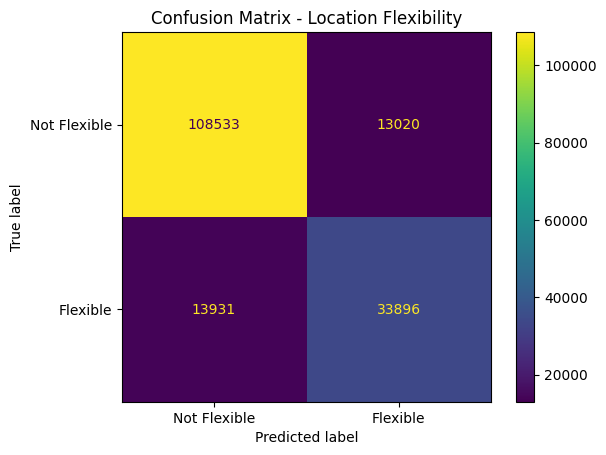

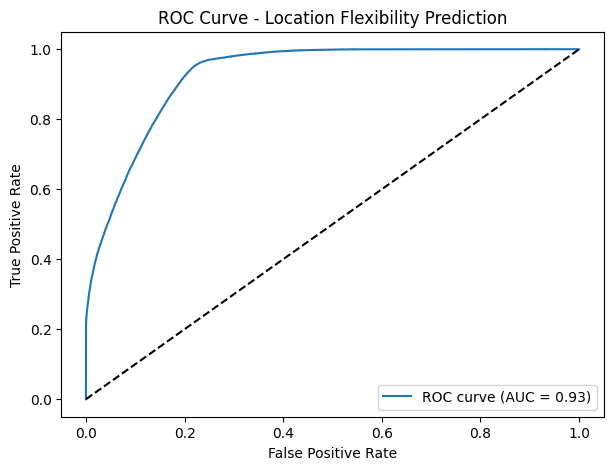

Top 10 features influencing location flexibility prediction:
city_Delhi                                                    -4.896875
city_Delhi,Faridabad,Ghaziabad,Gurgaon,Noida/ Greater Noida    4.280749
city_Delhi,Delhi/ NCR,Gurgaon                                  4.120440
city_Delhi/ NCR                                               -3.830095
city_Anywhere in India                                        -2.700370
city_Anywhere in North India                                  -1.943210
city_Delhi/ NCR,Gurgaon,Noida/ Greater Noida                   1.924251
city_Delhi,Delhi                                               1.615892
city_Delhi,Delhi/ NCR                                          1.550738
city_No Preference                                            -1.519938
dtype: float64


In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def prepare_features_for_location_flexibility(dataframe: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    """Prepare features and target for location flexibility prediction, removing data leakage."""
    # Select relevant features based on available columns and domain knowledge
    selected_features: list[str] = [
        "age",
        "Experience_Years",
        "level_ordinal",
        "industry_frequency",
        "industry_rank",
        "is_top_industry",
        "functional_area_frequency",
        # All city_ columns (location preferences, already one-hot)
        "city_Anywhere in India",
        "city_Anywhere in North India",
        "city_Delhi",
        "city_Delhi,Delhi",
        "city_Delhi,Delhi/ NCR",
        "city_Delhi,Delhi/ NCR,Gurgaon",
        "city_Delhi,Faridabad,Ghaziabad,Gurgaon,Noida/ Greater Noida",
        "city_Delhi/ NCR",
        "city_Delhi/ NCR,Gurgaon,Noida/ Greater Noida",
        "city_No Preference",
        "city_Other",
        # Skills diversity via tfidf features
        "skills_tfidf_0", "skills_tfidf_1", "skills_tfidf_2", "skills_tfidf_3", "skills_tfidf_4",
        "skills_tfidf_5", "skills_tfidf_6", "skills_tfidf_7", "skills_tfidf_8", "skills_tfidf_9",
        "skills_tfidf_10", "skills_tfidf_11", "skills_tfidf_12", "skills_tfidf_13", "skills_tfidf_14",
        "skills_tfidf_15", "skills_tfidf_16", "skills_tfidf_17", "skills_tfidf_18", "skills_tfidf_19",
        "skills_tfidf_20", "skills_tfidf_21", "skills_tfidf_22", "skills_tfidf_23", "skills_tfidf_24",
        "skills_tfidf_25", "skills_tfidf_26", "skills_tfidf_27", "skills_tfidf_28", "skills_tfidf_29",
        "skills_tfidf_30", "skills_tfidf_31", "skills_tfidf_32", "skills_tfidf_33", "skills_tfidf_34",
        "skills_tfidf_35", "skills_tfidf_36", "skills_tfidf_37", "skills_tfidf_38", "skills_tfidf_39",
        "skills_tfidf_40", "skills_tfidf_41", "skills_tfidf_42", "skills_tfidf_43", "skills_tfidf_44",
        "skills_tfidf_45", "skills_tfidf_46", "skills_tfidf_47", "skills_tfidf_48", "skills_tfidf_49",
        # Education (highest and second highest, one-hot)
        "course_highest_arts", "course_highest_commerce", "course_highest_computer", "course_highest_diploma",
        "course_highest_engineering", "course_highest_management", "course_highest_other", "course_highest_school",
        "course_highest_science",
        "course_second_arts", "course_second_commerce", "course_second_computer", "course_second_diploma",
        "course_second_engineering", "course_second_management", "course_second_other", "course_second_school",
        "course_second_science",
        # Specialization (highest and second highest, one-hot)
        "spec_highest_Arts & Humanities", "spec_highest_Commerce", "spec_highest_Commerce Honors",
        "spec_highest_Commerce Pass", "spec_highest_Computers", "spec_highest_Electronics/Telecommunication",
        "spec_highest_Finance", "spec_highest_Marketing", "spec_highest_Mechanical", "spec_highest_Others",
        "spec_highest_other",
        "spec_second_Arts Humanities", "spec_second_Commerce", "spec_second_Commerce Honors",
        "spec_second_Commerce Pass", "spec_second_Computers", "spec_second_Maths", "spec_second_Other B.Com",
        "spec_second_Others", "spec_second_Science", "spec_second_Unknown", "spec_second_other",
        # Simple course and specialization groupings
        "course_highest_simple_commerce", "course_highest_simple_computer", "course_highest_simple_diploma",
        "course_highest_simple_engineering", "course_highest_simple_management", "course_highest_simple_other",
        "course_highest_simple_school", "course_highest_simple_science",
        "course_second_simple_commerce", "course_second_simple_computer", "course_second_simple_diploma",
        "course_second_simple_engineering", "course_second_simple_management", "course_second_simple_other",
        "course_second_simple_school", "course_second_simple_science",
        # Top10 specialization flags
        "specialization_highest_top10_Commerce", "specialization_highest_top10_Commerce Honors",
        "specialization_highest_top10_Commerce Pass", "specialization_highest_top10_Computers",
        "specialization_highest_top10_Electronics/Telecommunication", "specialization_highest_top10_Finance",
        "specialization_highest_top10_Marketing", "specialization_highest_top10_Mechanical",
        "specialization_highest_top10_Others", "specialization_highest_top10_other",
        "specialization_second_top10_Commerce", "specialization_second_top10_Commerce Honors",
        "specialization_second_top10_Commerce Pass", "specialization_second_top10_Computers",
        "specialization_second_top10_Maths", "specialization_second_top10_Other B.Com",
        "specialization_second_top10_Others", "specialization_second_top10_Science",
        "specialization_second_top10_Unknown", "specialization_second_top10_other"
    ]
    # Only keep features that exist in the dataframe
    available_features: list[str] = [f for f in selected_features if f in dataframe.columns]
    X: pd.DataFrame = dataframe[available_features].copy()
    y: pd.Series = dataframe["preferred_location_flexible"].astype(int)
    return X, y

def run_logistic_regression_location_flexibility(dataframe: pd.DataFrame) -> None:
    """Train and evaluate logistic regression for location flexibility prediction."""
    X: pd.DataFrame
    y: pd.Series
    X, y = prepare_features_for_location_flexibility(dataframe)
    X_train: pd.DataFrame
    X_test: pd.DataFrame
    y_train: pd.Series
    y_test: pd.Series
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    model: LogisticRegression = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred_proba: np.ndarray = model.predict_proba(X_test)[:, 1]
    y_pred: np.ndarray = model.predict(X_test)
    roc_auc: float = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC: {roc_auc:.3f}")
    print(classification_report(y_test, y_pred, target_names=["Not Flexible", "Flexible"]))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=["Not Flexible", "Flexible"])
    plt.title("Confusion Matrix - Location Flexibility")
    plt.show()
    fpr: np.ndarray
    tpr: np.ndarray
    thresholds: np.ndarray
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Location Flexibility Prediction")
    plt.legend(loc="lower right")
    plt.show()
    feature_names: list[str] = X.columns.tolist()
    coefficients: np.ndarray = model.coef_[0]
    feature_importance: pd.Series = pd.Series(coefficients, index=feature_names).sort_values(key=abs, ascending=False)
    print("Top 10 features influencing location flexibility prediction:")
    print(feature_importance.head(10))

run_logistic_regression_location_flexibility(df)
